# Classification of FSL Alphabet Images using MediaPipe Hands

Objectives:
- extract hand landmark keypoints from images
- perform classification using SVM with different kernels
- compare classification reports
- create a live webcam interpreter

## Modules for Implementation

### FSL Dataset Modules

In [4]:
import zipfile
import collections
import numpy as np

def zip_path_2_filenames(zip_path):
    file_names = []
    with zipfile.ZipFile(zip_path, 'r') as zip:
        for file_info in zip.infolist():
            file_names.append(file_info.filename)
    return file_names

def get_files_per_class(images, folders):
    image_and_class = collections.defaultdict(list)

    # extracts class number from the folder name
    for folder in folders:
        class_key = folder[-2]
        for image in images:
            if folder in image:
                image_and_class[class_key].append(image)
    return image_and_class

def subset_data(files, num_classes, num_images):
    subset = {k: files[k][:num_images] for k in np.sort(list(files))[:num_classes]}
    return subset, list(subset.keys())

def reconstruct_data(file_subset, class_subset):
    dataset = {'data': [], 'target': []}
    for k in class_subset:
        [dataset['data'].append(file) for file in file_subset[k]]
        [dataset['target'].append(k) for file in file_subset[k]]
    dataset['data'], dataset['target'] = np.array(dataset['data']), np.array(dataset['target'])
    return dataset

def load_fsl(zip_path, num_classes, num_images) -> dict:
    # zip file to folder and filenames
    folder_and_file_names = zip_path_2_filenames(zip_path)
    images = [f for f in folder_and_file_names if f.endswith('jpg')]
    folders = [f for f in folder_and_file_names if not f.endswith('jpg')]

    # dictionary of image per class
    complete_files = get_files_per_class(images, folders)

    # subset of files
    file_subset, class_subset = subset_data(complete_files, num_classes, num_images)

    # reconstruction of data
    dataset = reconstruct_data(file_subset, class_subset)
    return dataset

### MediaPipe Modules

In [6]:
from mediapipe import solutions
import cv2
import matplotlib.pyplot as plt

# for building keypoints
mp_hands = solutions.hands
mp_drawing = solutions.drawing_utils
mp_drawing_styles = solutions.drawing_styles

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_hand_landmarks(image, results):
    annotated_image = image.copy()
    if results.multi_hand_landmarks:
        for num, hand in enumerate(results.multi_hand_landmarks):
            mp_drawing.draw_landmarks(annotated_image, hand, mp_hands.HAND_CONNECTIONS,
                                      mp_drawing.DrawingSpec(color=(54, 69, 79), thickness=2, circle_radius=2),
                                      mp_drawing.DrawingSpec(color=(229, 228, 226), thickness=2, circle_radius=2))
    return annotated_image

def extract_landmarks(results, flattened):
    hand_landmarks = None  # 21 landmarks, 3 keypoints, 1 hand
    if results.multi_handedness:
        hand_landmarks = np.array([[res.x, res.y, res.z] for res in results.multi_hand_landmarks[0].landmark])
        if flattened == 1:
            hand_landmarks = hand_landmarks.flatten()

    return hand_landmarks

def image_to_hand_landmarks(image_path:str, flattened:int=1, display_image:bool=True):
    image = cv2.imread(image_path)
    # image = cv2.resize(image, (150, 150))

    with mp_hands.Hands(model_complexity=1, max_num_hands=2, min_tracking_confidence=0.5) as hands:
        image, results = mediapipe_detection(image, hands)

        # extract keypoints
        hand_landmarks = extract_landmarks(results, flattened)

        # displaying
        if display_image:
            annotated_image = draw_hand_landmarks(image, results)
            plt.imshow(annotated_image)
            plt.axis('off')

    return hand_landmarks

def normalize_landmarks(FSLData):
    FSLData_normalized = (FSLData.copy()).reshape(-1,21,3)
    for idx, data in enumerate(FSLData):
        data = data.reshape(21,3)
        first_row = np.array(data[0].copy())
        FSLData_normalized[idx] = [np.abs(first_row - np.array(data[i])).tolist() for i in range(len(data))]
    return FSLData_normalized.reshape(-1, 21*3)

### Classification Modules

In [7]:
import math
from sklearn.metrics import confusion_matrix, classification_report

# balancing number of datapoints per class
def balance_data(dataset):
    balanced_dataset = {'data': [], 'target': [], 'path': []}
    # removing None data values
    rem_idx = []
    for idx, data in enumerate(dataset['data']):
        if data is None:
            rem_idx.append(idx)

    rem_idx.sort(reverse=True)
    for idx in rem_idx:
        dataset['data'].pop(idx)
        dataset['target'].pop(idx)
        dataset['path'].pop(idx)

    # balancing num of data per class according to minimum
    classes = np.unique(dataset['target'])
    numdata_per_class = min([len(np.where(np.array(dataset['target']) == c)[0]) for c in classes])
    keep_idx = []
    for c in classes:
        keep = np.where(np.array(dataset['target']) == c)[0][:numdata_per_class]
        keep_idx.extend(keep)
    balanced_dataset['data'] = [dataset['data'][idx] for idx in keep_idx]
    balanced_dataset['target'] = [dataset['target'][idx] for idx in keep_idx]
    balanced_dataset['path'] = [dataset['path'][idx] for idx in keep_idx]
    return np.array(balanced_dataset['data']), np.array(balanced_dataset['target']), np.array(balanced_dataset['path'])

def get_specificity(confusionMatrix, classes):
    label_lists = classes
    specificity = {}
    for l, label in enumerate(label_lists):
        tp, tn, fp, fn = 0, 0, 0, 0
        tp = confusionMatrix[l, l]
        fn = sum(confusionMatrix[l]) - tp
        for i in range(len(label_lists)):
            for j in range(len(label_lists)):
                if i == l or j == l:
                    continue
                else:
                    tn += confusionMatrix[i,j]
        for i in range(len(label_lists)):
            if i==l:
                continue
            else:
                fp += confusionMatrix[l][i]
        specificity[str(label)] = tn/(tn+fp)
    return specificity

def plot_metrics(predicted_labels, true_labels, measurements):
  colors = ['#3a2f6b','#36669c','#41a0ae','#3ec995','#77f07f']
  report = classification_report(true_labels, predicted_labels, output_dict=True)
  labels = np.unique(true_labels)
  metric_values = []
  metrics = measurements.copy()
  metrics.remove('support')
  specificity = get_specificity(confusion_matrix(true_labels, predicted_labels, labels=labels), labels)
  for metric in metrics:
    if metric == 'accuracy':
      value = report[metric]
    elif metric == 'specificity':
      value = np.mean([specificity[clss] for clss in labels])
    else:
      value = np.mean([report[clss][metric] for clss in labels])
    metric_values.append(value)

  b = plt.bar(np.arange(len(metric_values)), metric_values, color=colors)
  plt.bar_label(b, fmt='%.2f', label_type='center')
  plt.xticks(np.arange(len(metrics)), metrics, rotation='vertical')

def plot_predictions(y_pred, y_test, test_ind, num_images, landmarks:bool, title, img_paths):
  if title == 'Correct':
    indices = test_ind[np.nonzero(y_pred == y_test)[0]]
  else:
    indices = test_ind[np.nonzero(y_pred != y_test)[0]]
  num_axs = int(np.sqrt(num_images))


  plt.figure(figsize=(10,10))
  for i, correct, in enumerate(indices[:num_images]):
    plt.subplot(num_axs, num_axs, i+1)
    if title == "Correct":
      pred_ind = np.nonzero(y_pred == y_test)[0][i]
    else:
      pred_ind = np.nonzero(y_pred != y_test)[0][i]

    if landmarks:
      _ = image_to_hand_landmarks(img_paths[correct], display_image=True)
    else:
      img = cv2.imread(img_paths[correct])
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted {y_pred[pred_ind]}, Class {y_test[pred_ind]}")
    plt.axis('off')
  plt.suptitle(f'{title} Predictions')
  plt.tight_layout()
  plt.show()

## Main Implementation

### Parameters

In [1]:
classes = 24
data_per_class = 450
zip_path = f'FSL_images_24only.zip'
data_name = f'FSLR_MP_{classes}classes'
classificationMeasurements = ['precision', 'recall', 'f1-score', 'specificity', 'support', 'accuracy']

### Dataset Collection

In [12]:
# saving paths
print('Collecting keypoints from each image in the dataset --------')
dataset_paths = load_fsl(zip_path, num_classes=classes, num_images=data_per_class)
print('Collection complete.')

Collection complete.


In [ ]:
# run only if the extracted landmarks are not yet available
from tqdm import tqdm

num_data = len(dataset_paths['target'])
FSL_dataset = {'data': [], 'target': [], 'path': []}

for n in range(tqdm(num_data)):
    image_path = dataset_paths['data'][n]
    hand_landmarks = image_to_hand_landmarks(image_path, flattened=1, display_image=False)
    FSL_dataset['data'].append(hand_landmarks)
    FSL_dataset['target'].append(dataset_paths['target'][n])
    FSL_dataset['path'].append(dataset_paths['data'][n])
    print(f'{n+1}/{num_data} data collected ...')

# save FSL_dataset into an npy file
np.save(f'FSL_img_dataset_MediaPipe_{str(classes)}classes.npy', FSL_dataset)

print('Data collection finished and saved. Keypoints extracted using MediaPipe Holistic.')

'FSL_images/Y/276.jpg'

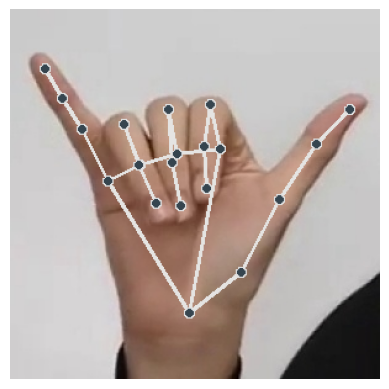

In [14]:
# sample image
img_path = 'FSL_images/Y/276.jpg'
landmarks = image_to_hand_landmarks(img_path, flattened=1, display_image=True)
img_path

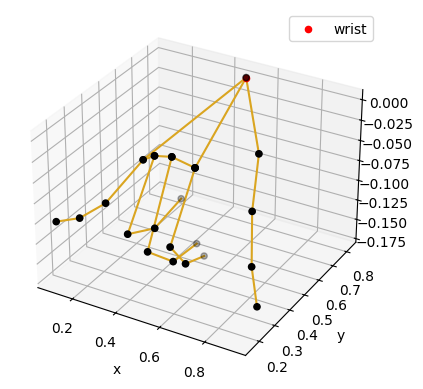

In [15]:
def connect_landmarks(landmarks):
  landmarks = landmarks.reshape(21,3)
  connected_landmarks = []
  for con in mp_hands.HAND_CONNECTIONS:
    node1, node2 = landmarks[con[0]], landmarks[con[1]]
    x, y, z = (node1[0], node2[0]), (node1[1], node2[1]), (node1[2], node2[2])
    connected_landmarks.append([x,y,z])
  return connected_landmarks

connected_landmarks = connect_landmarks(landmarks)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(connected_landmarks)):
  points = connected_landmarks[i]
  x, y, z = points[0], points[1], points[2]
  ax.plot(x,y,z, color='goldenrod', alpha=1)
  ax.scatter(x,y,z, color='k')
  # ax.view_init(elev=30, azim=90)

wrist = landmarks.reshape(21,3)[0,:]
ax.scatter(wrist[0], wrist[1], wrist[2], c='r', alpha=1, label='wrist')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [16]:
# loading dataset from npy file
FSL_dataset = np.load(f'FSL_img_dataset_MediaPipe_{str(classes)}classes.npy', allow_pickle=True)
FSL_dataset = {'data': FSL_dataset.item().get('data'),
               'target': FSL_dataset.item().get('target'),
               'path': FSL_dataset.item().get('path')}
len(FSL_dataset['target'])

10800

In [17]:
# removing None data values and balancing numdata per class
FSLData, FSLTarget, FSLPath = balance_data(FSL_dataset)
print(f'The data consists of {FSLData.shape[0]} datapoints with {FSLData.shape[1]} features each.')
print(f'That is, we have {int(FSLData.shape[0]/classes)} datapoints per class.')

The data consists of 7512 datapoints with 63 features each.
That is, we have 313 datapoints per class.


In [ ]:
# normalize data (check first if necessary)
FSLData = normalize_landmarks(FSLData)
FSLData.shape

(8398, 63)

### Data Preparation, Training and Testing

In [18]:
# data preparation
from sklearn.model_selection import train_test_split

indices = np.arange(len(FSLTarget))
X_train, X_test, y_train, y_test, train_ind, test_ind = train_test_split(FSLData, FSLTarget, indices, test_size=0.2, random_state=0)
print(f'X_train shape: {X_train.shape}   X_test shape: {X_test.shape}')

X_train shape: (6009, 63)   X_test shape: (1503, 63)


In [19]:
# Scaling data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
from sklearn import svm

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
SVM_linear = svm.SVC(kernel='linear')
SVM_rbf = svm.SVC(kernel='rbf')
SVM_poly = svm.SVC(kernel='poly')
SVM_sigmoid = svm.SVC(kernel='sigmoid')


SVM_linear.fit(X_train, y_train)
SVM_rbf.fit(X_train, y_train)
SVM_poly.fit(X_train, y_train)
SVM_sigmoid.fit(X_train, y_train)

SVC(kernel='sigmoid')

In [21]:
# save Standard Scaler and SVM Model
import pickle

for k, model in enumerate([SVM_linear, SVM_rbf, SVM_poly, SVM_sigmoid]):
  pickle.dump(model, open(f'trained_SVM_{kernels[k]}_{classes}classes.sav', 'wb'))
pickle.dump(scaler, open(f'trained_scaler{classes}.sav', 'wb'))

### Classification Report

In [ ]:
from sklearn.metrics import classification_report

y_pred_linear = SVM_linear.predict(X_test)
y_pred_rbf = SVM_rbf.predict(X_test)
y_pred_poly = SVM_poly.predict(X_test)
y_pred_sigmoid = SVM_sigmoid.predict(X_test)

for k, prediction in enumerate([y_pred_linear, y_pred_rbf, y_pred_poly, y_pred_sigmoid]):
  np.save(f'predicted_labels_{kernels[k]}_{classes}classes.npy', prediction)

print(classification_report(y_test, y_pred_linear))

In [ ]:
print(classification_report(y_test, y_pred_sigmoid))

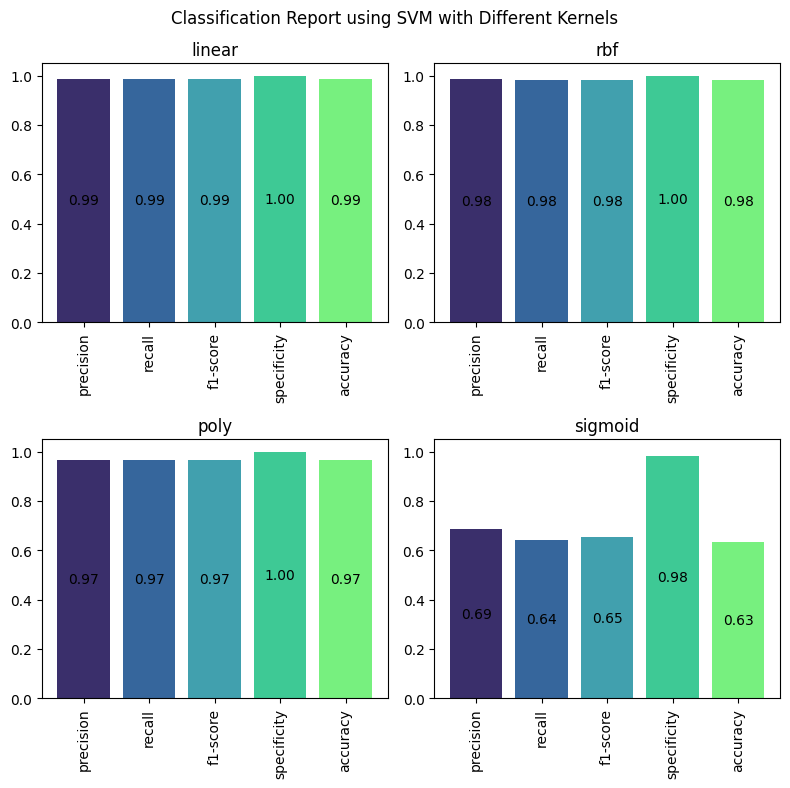

In [23]:
# plot classification reports
plt.figure(figsize=(8,8))
for i, y_pred in enumerate([y_pred_linear, y_pred_rbf, y_pred_poly, y_pred_sigmoid]):
  plt.subplot(2,2, i+1)
  plot_metrics(y_pred, y_test, classificationMeasurements)
  plt.ylim([0, 1.05])
  plt.title(kernels[i])

plt.suptitle('Classification Report using SVM with Different Kernels')
plt.tight_layout()
plt.show()

<Figure size 1500x1500 with 0 Axes>

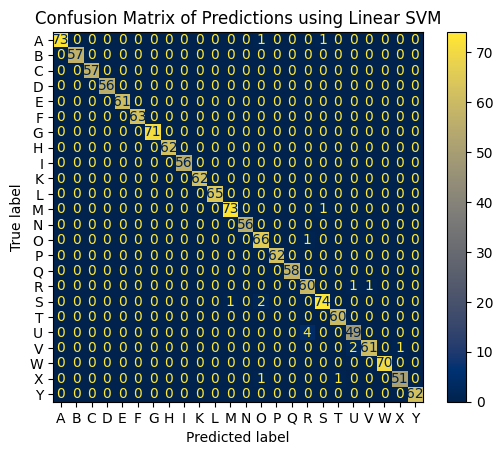

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = np.unique(FSLTarget)
cf = confusion_matrix(y_true=y_test, y_pred=y_pred_linear, labels=labels)

# plot confusion matrix
plt.figure(figsize=(15,15))
disp = ConfusionMatrixDisplay(cf, display_labels=labels)
disp.plot(cmap='cividis')
plt.title('Confusion Matrix of Predictions using Linear SVM')
plt.show()

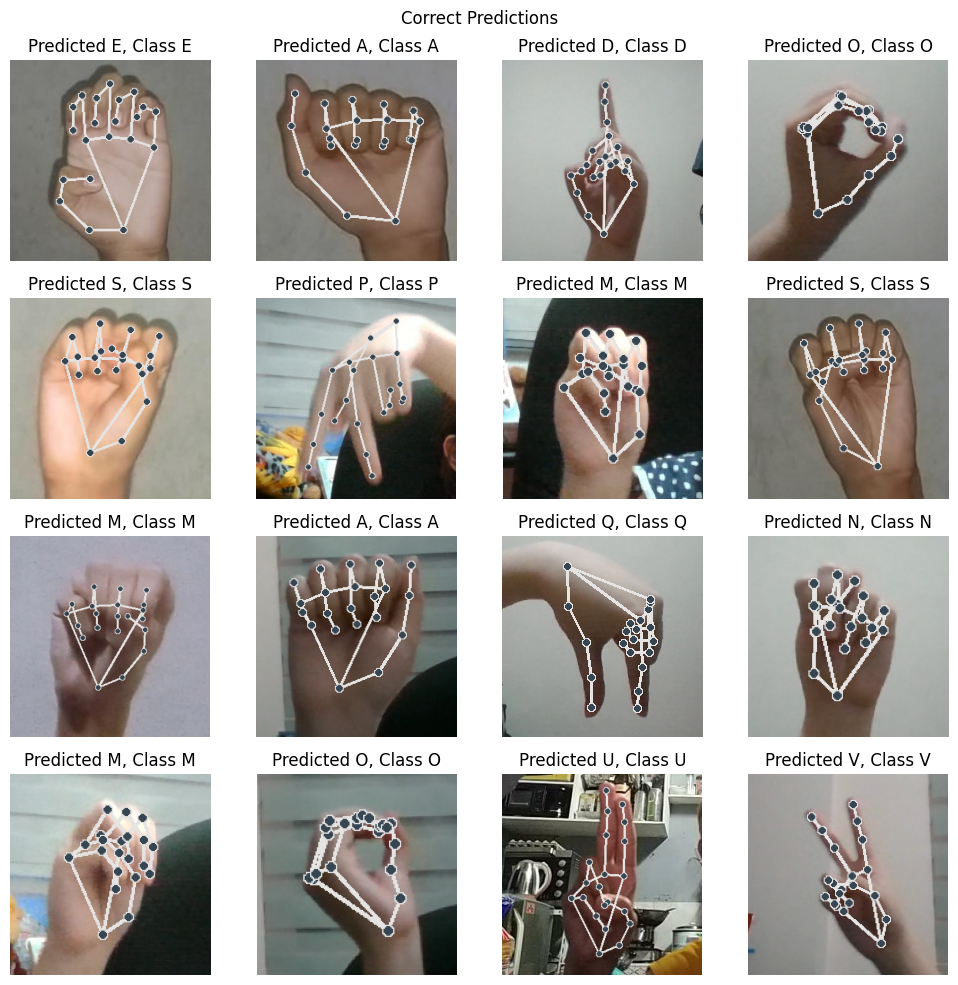

In [28]:
# plot correct predictions
plot_predictions(y_pred_linear, y_test, test_ind, num_images=16, landmarks=True, title='Correct', img_paths=FSLPath)

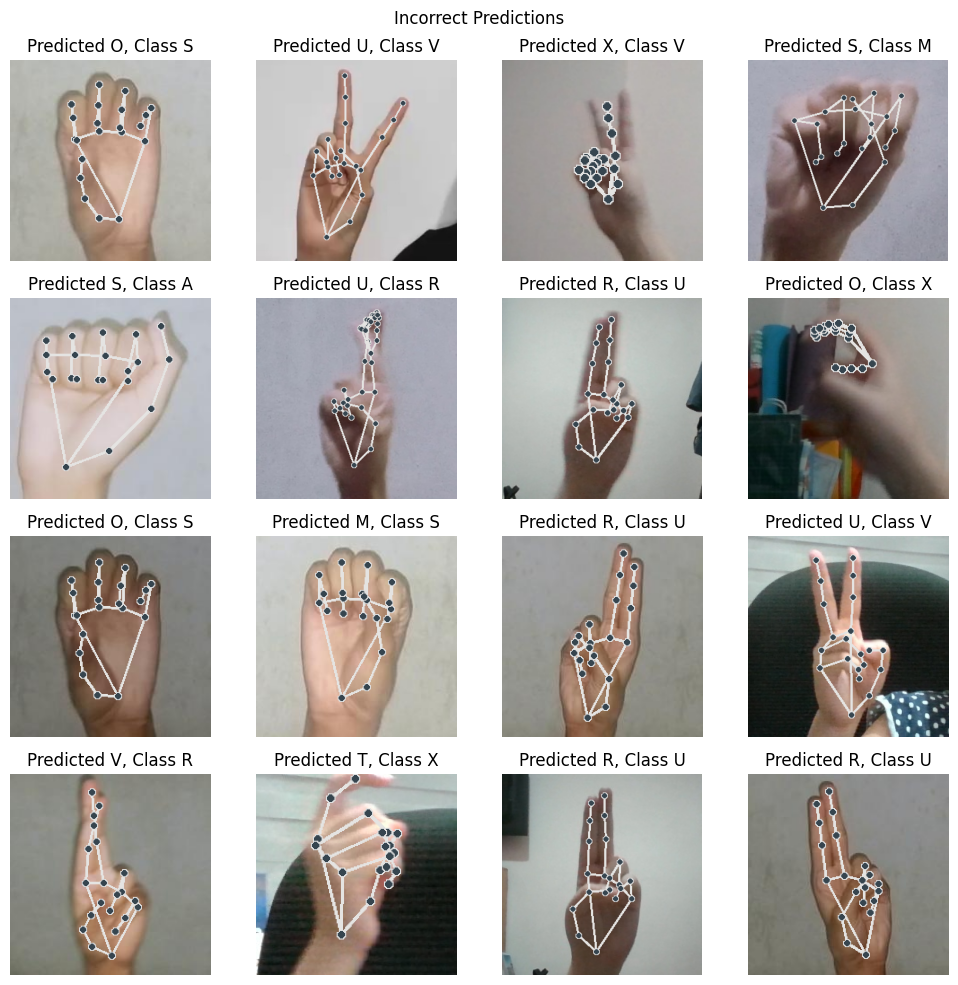

In [30]:
# plot incorrect predictions
plot_predictions(y_pred_linear, y_test, test_ind, 16, landmarks=True, title='Incorrect', img_paths=FSLPath)

### Classify Live Feed

In [2]:
import pickle

classes = 24
# loading saved scaler and SVM model(s)
SVM_linear = pickle.load(open(f'trained models/trained_SVM_linear_{classes}classes.sav', 'rb'))
scaler = pickle.load(open(f'trained models/trained_scaler{classes}.sav', 'rb'))

In [4]:
from module_Classify_VideoFeed import HandDetector
import cv2

cap = cv2.VideoCapture(0)
detector = HandDetector(scaler, SVM_linear, maxHands=2)
while cap.isOpened():
    ret, frame = cap.read()
    flipped_frame = cv2.flip(frame,1)
    # hands, img = detector.findHands(flipped_frame, flipType=False)
    hands, img = detector.classify_hand_to_letter(flipped_frame, flipType=False)

    cv2.imshow("Live Feed", flipped_frame)
    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


## Debugging

In [ ]:
def predict_landmark(landmark_list, scaler, classifier):
    """
    Prepare landmarks before classification (normalize -> scale -> classify)
    :param landmark_list: List of landmarks of hand with shape (21,3)
    :scaler: Standard Scaler
    :classifier: Machine Learning classifier
    :return: Classified letter
    """
    landmark_list = normalize_landmarks(np.array(landmark_list).reshape(1, 63))
    test_data = scaler.transform(landmark_list)
    prediction = classifier.predict(test_data)
    return prediction[0]

In [ ]:
def classify_hand_to_letter(img, scaler, classifier, static_mode=False, draw=True, flipType=True):
    """
    detect hands from image and extract keypoints
    :param img: Image to find the hands from.
    :param draw: Flag to draw to output on the image.
    :return:Image with or without the interpreted letter
    """
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = imgRGB.shape
    hands = mp_hands.Hands(static_image_mode=static_mode, max_num_hands=2, model_complexity=1, min_tracking_confidence=0.5)
    results = hands.process(imgRGB)
    allHands = []
    if results.multi_hand_landmarks:
        for handType, landmarks in zip(results.multi_handedness, results.multi_hand_landmarks):
            myHand = {}
            landmark_list = []
            xList, yList = [], []
            for lm in landmarks.landmark:
                landmark_list.append([lm.x, lm.y, lm.z])
                xList.append(int(lm.x * width))
                yList.append(int(lm.y * height))

            ## classify hand from landmarks
            predLabel = predict_landmark(landmark_list, scaler, classifier)

            ## bbox
            xmin, xmax = min(xList), max(xList)
            ymin, ymax = min(yList), max(yList)
            boxW, boxH = xmax - xmin, ymax - ymin
            bbox = xmin, ymin, boxW, boxH
            cx, cy = bbox[0] + (bbox[2] // 2), \
                        bbox[1] + (bbox[3] // 2)

            myHand["center"] = (cx, cy)
            myHand["bbox"] = bbox
            myHand["center"] = (cx, cy)
            myHand['label'] = predLabel

            if flipType:
                if handType.classification[0].label == "Right":
                    myHand["type"] = "Left"
                else:
                    myHand["type"] = "Right"
            else:
                myHand["type"] = handType.classification[0].label
            allHands.append(myHand)


            ## draw
            if draw:
                mp_drawing.draw_landmarks(img, landmarks, mp_hands.HAND_CONNECTIONS)
                cv2.rectangle(img, (bbox[0] - 20, bbox[1] - 20),
                                  (bbox[0] + bbox[2] + 20, bbox[1] + bbox[3] + 20),
                                  (255, 0, 255), 2)
                # cv2.putText(img, myHand["type"], (bbox[0] - 30, bbox[1] - 30), cv2.FONT_HERSHEY_PLAIN,
                #                 2, (255, 0, 255), 2)
                cv2.putText(img, myHand["label"], (bbox[0] - 30, bbox[1] - 30), cv2.FONT_HERSHEY_PLAIN,
                                2, (255, 0, 255), 2)

    return allHands, img

In [ ]:
hands, img = classify_hand_to_letter(cv2.imread('sample_img.jpg'), scaler, SVM, static_mode=True)

In [ ]:
from module_Classify_VideoFeed import classify_hand_to_letter
import time
cap = cv2.VideoCapture(0)
offset = 20
maxDuration = 3
t0 = time.time()
while cap.isOpened():
    ret, frame = cap.read()
    flipped_frame = cv2.flip(frame,1)
    # hands, img = detector.findHands(flipped_frame, flipType=False)
    hands, img = classify_hand_to_letter(flipped_frame, scaler, SVM, flipType=False)

    # if hands:
    #     try:
    #         hand = hands[0]
    #         x, y, w, h = hand['bbox']
    #         imgCrop = img[y-offset:y+h+offset, x-offset:x+w+offset]
    #         # cv2.imshow("Cropped Hand", imgCrop)
    #     except:
    #         pass

    cv2.imshow("Live Feed", flipped_frame)
    num_seconds = time.time() - t0
    if num_seconds == maxDuration:
        break
    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

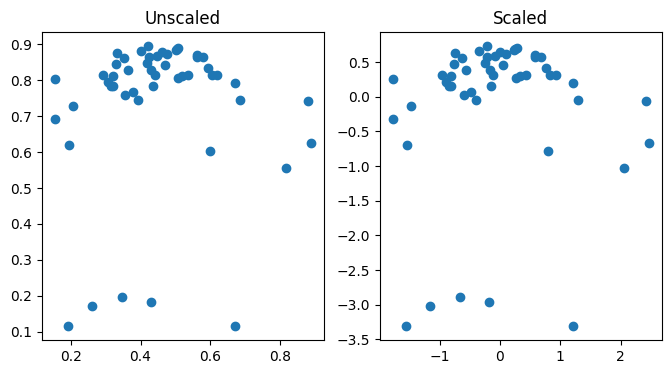

In [52]:
X_train_unscaled = X_train.copy()
X_train_scaled = StandardScaler().fit_transform(X_train_unscaled)

unscaled = X_train_unscaled[:,:2]
scaled = X_train_scaled[:,:2]

numdata = 50
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs = axs.flatten()
axs[0].scatter(unscaled[:numdata,0], unscaled[:numdata,1])
axs[0].set_title('Unscaled')
axs[1].scatter(scaled[:numdata,0], scaled[:numdata,1])
axs[1].set_title('Scaled')
plt.show()